## Baseline CNN Model

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
RTX 3060 GPU configured successfully
GPU Memory limited to 5GB
Mixed precision enabled for Tensor Cores
System RAM: 15.7 GB
Available RAM: 8.2 GB
Starting 16GB RAM + RTX 3060 optimized training...
RAM Usage: 7.5GB (48.1%)
GPU Memory - Current: 0MB, Peak: 0MB
Verifying directory structure...
  E:\covid_xray_classification\data\train\NORMAL: 7134 images
  E:\covid_xray_classification\data\train\COVID: 2531 images
  E:\covid_xray_classification\data\val\NORMAL: 1528 images
  E:\covid_xray_classification\data\val\COVID: 542 images
  E:\covid_xray_classification\data\test\NORMAL: 1530 images
  E:\covid_xray_classification\data\test\COVID: 543 images
Directory structure verified!

Loading dataset paths...
Scanning directory: E:\covid_xray_class

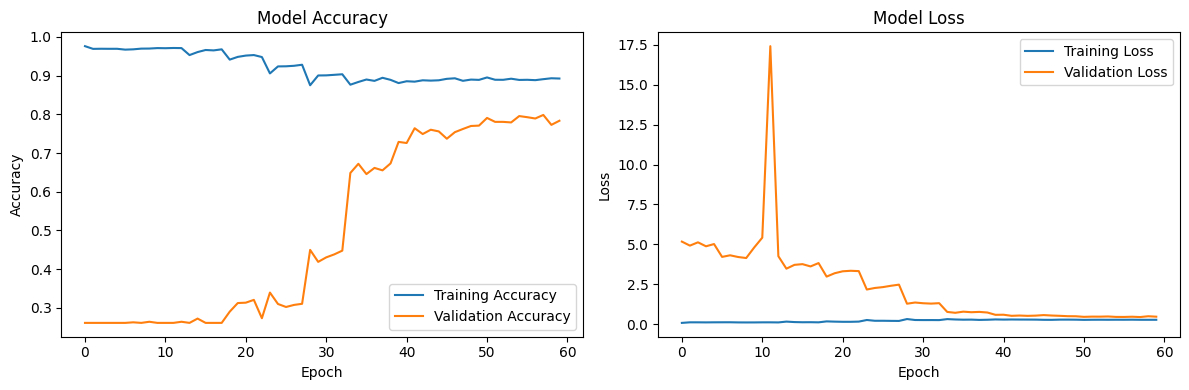

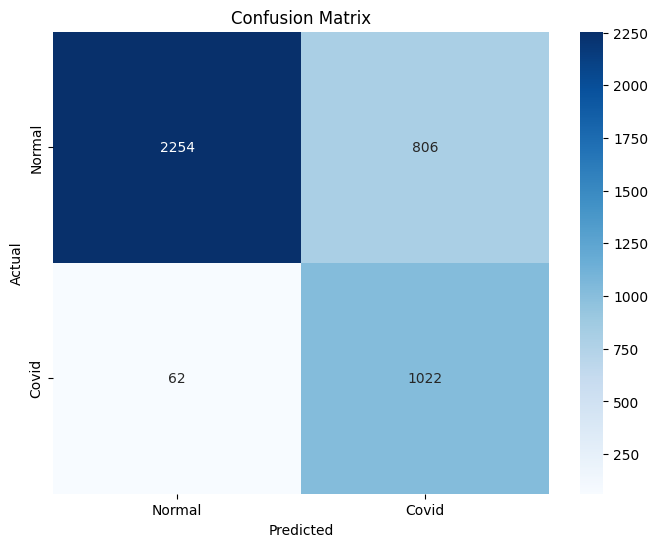


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.74      0.84      3060
       COVID       0.56      0.94      0.70      1084

    accuracy                           0.79      4144
   macro avg       0.77      0.84      0.77      4144
weighted avg       0.86      0.79      0.80      4144


Model saved to: E:\covid_xray_classification\data\covid_model.h5

Final System Resources:
RAM Usage: 10.2GB (65.0%)
GPU Memory - Current: 30MB, Peak: 228MB
Training completed successfully!

Final Training Accuracy: 0.8924
Final Validation Accuracy: 0.7834


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import psutil
import sys
import glob
from PIL import Image

# RTX 3060 + 16GB RAM Configuration
def configure_system_for_16gb_ram():
    # GPU Configuration
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Set memory growth to avoid allocating all 6GB at once
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            # Limit GPU memory to 5GB (leaving 1GB for system)
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
            )
            
            # Enable mixed precision for RTX 3060 (has Tensor Cores)
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            
            print("RTX 3060 GPU configured successfully")
            print(f"GPU Memory limited to 5GB")
            print("Mixed precision enabled for Tensor Cores")
            
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
    else:
        print("No GPU detected - running on CPU")
    
    # RAM Management
    print(f"System RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
    print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")
    
    # Set TensorFlow to use less CPU memory
    tf.config.threading.set_inter_op_parallelism_threads(4)
    tf.config.threading.set_intra_op_parallelism_threads(4)

# Configure system
configure_system_for_16gb_ram()

# Set your data root path
data_root = r"E:\covid_xray_classification\data"

def validate_image_file(file_path):
    try:
        # Try to open with PIL first
        with Image.open(file_path) as img:
            img.verify()  # Verify it's a valid image
        
        # Try to open again for actual reading (verify() closes the file)
        with Image.open(file_path) as img:
            img.load()  # Actually load the image data
            
        return True
    except Exception as e:
        print(f"Invalid image file {file_path}: {e}")
        return False

def get_image_paths_and_labels(data_dir):

    image_paths = []
    labels = []
    
    # Define class names and their corresponding labels
    class_names = ['NORMAL', 'COVID']  # 0 for Normal, 1 for COVID
    
    print(f"Scanning directory: {data_dir}")
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist!")
            continue
            
        print(f"  Looking in: {class_dir}")
        
        # Get all image files with common extensions
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']
        
        class_images = []
        for ext in image_extensions:
            class_images.extend(glob.glob(os.path.join(class_dir, ext)))
            class_images.extend(glob.glob(os.path.join(class_dir, ext.upper())))
        
        print(f"    Found {len(class_images)} potential images in {class_name}")
        
        # Validate each image file
        valid_images = []
        for img_path in class_images:
            if validate_image_file(img_path):
                valid_images.append(img_path)
        
        print(f"    Validated {len(valid_images)} images in {class_name}")
        
        # Add to lists
        image_paths.extend(valid_images)
        labels.extend([class_idx] * len(valid_images))
    
    print(f"Total valid images found: {len(image_paths)}")
    print(f"Label distribution: Normal={labels.count(0)}, COVID={labels.count(1)}")
    
    return image_paths, labels

def verify_directory_structure(data_root):

    print("Verifying directory structure...")
    
    required_dirs = ['train', 'val', 'test']
    class_dirs = ['NORMAL', 'COVID']
    
    for split in required_dirs:
        split_path = os.path.join(data_root, split)
        if not os.path.exists(split_path):
            print(f"ERROR: Missing directory: {split_path}")
            return False
        
        for class_name in class_dirs:
            class_path = os.path.join(split_path, class_name)
            if not os.path.exists(class_path):
                print(f"ERROR: Missing directory: {class_path}")
                return False
            
            # Count files in directory
            files = glob.glob(os.path.join(class_path, '*'))
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'))]
            print(f"  {class_path}: {len(image_files)} images")
    
    print("Directory structure verified!")
    return True

def create_memory_efficient_dataset(image_paths, labels, img_size=(224, 224), batch_size=8, is_training=True):

    def load_and_preprocess_image(img_path, label):
        try:
            # Load image file
            img = tf.io.read_file(img_path)
            
            # Decode image with explicit format detection
            img = tf.cond(
                tf.image.is_jpeg(img),
                lambda: tf.image.decode_jpeg(img, channels=1),
                lambda: tf.image.decode_png(img, channels=1)
            )
            
            # Ensure the image has the expected shape
            img = tf.ensure_shape(img, [None, None, 1])
            
            # Resize image
            img = tf.image.resize(img, img_size)
            
            # Convert to float32 and normalize
            img = tf.cast(img, tf.float32) / 255.0
            
            # Light data augmentation only for training
            if is_training:
                if tf.random.uniform([]) > 0.7:
                    img = tf.image.random_brightness(img, 0.1)
                if tf.random.uniform([]) > 0.7:
                    img = tf.image.random_contrast(img, 0.9, 1.1)
                if tf.random.uniform([]) > 0.5:
                    img = tf.image.flip_left_right(img)
            
            # Ensure final shape
            img = tf.ensure_shape(img, [img_size[0], img_size[1], 1])
            
            return img, label
            
        except Exception as e:
            # Return a black image if loading fails
            print(f"Failed to load image {img_path}: {e}")
            img = tf.zeros([img_size[0], img_size[1], 1], dtype=tf.float32)
            return img, label
    
    # Create dataset from paths (minimal memory usage)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=500)  # Reduced buffer size
    
    # Load images on-demand with minimal parallel processing
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_ram_efficient_model(input_shape=(224, 224, 1)):

    model = Sequential([
        # Efficient architecture with fewer parameters
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(96, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(96, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Smaller dense layers to reduce memory footprint
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    return model

def monitor_system_resources():

    # RAM monitoring
    ram = psutil.virtual_memory()
    ram_used_gb = (ram.total - ram.available) / (1024**3)
    ram_percent = ram.percent
    
    print(f"RAM Usage: {ram_used_gb:.1f}GB ({ram_percent:.1f}%)")
    
    # GPU memory monitoring
    if tf.config.list_physical_devices('GPU'):
        try:
            gpu_info = tf.config.experimental.get_memory_info('GPU:0')
            gpu_current_mb = gpu_info['current'] / 1024 / 1024
            gpu_peak_mb = gpu_info['peak'] / 1024 / 1024
            print(f"GPU Memory - Current: {gpu_current_mb:.0f}MB, Peak: {gpu_peak_mb:.0f}MB")
        except:
            print("GPU memory info not available")

def plot_confusion(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=["Normal", "Covid"], 
                yticklabels=["Normal", "Covid"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Memory-aware callback
class MemoryMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_count = 0
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % 3 == 0:  # Monitor every 3 epochs
            print(f"\nEpoch {epoch + 1} - System Resources:")
            monitor_system_resources()
            
            # Force garbage collection
            gc.collect()
            
            # Check if RAM usage is too high
            ram_percent = psutil.virtual_memory().percent
            if ram_percent > 85:
                print(f"WARNING: RAM usage high ({ram_percent:.1f}%)")

def get_predictions_memory_efficient(model, dataset):

    y_pred = []
    y_true = []
    
    batch_count = 0
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_pred.extend((predictions > 0.5).astype(int).flatten())
        y_true.extend(labels.numpy())
        
        batch_count += 1
        # Clear memory every 20 batches
        if batch_count % 20 == 0:
            gc.collect()
    
    return y_true, y_pred

def test_image_loading(image_paths, num_test=5):

    print(f"\nTesting image loading with {min(num_test, len(image_paths))} images...")
    
    for i, img_path in enumerate(image_paths[:num_test]):
        try:
            print(f"Testing image {i+1}: {img_path}")
            
            # Test with PIL
            with Image.open(img_path) as img:
                print(f"  PIL: {img.size}, {img.mode}")
            
            # Test with TensorFlow
            img_raw = tf.io.read_file(img_path)
            img_tensor = tf.cond(
                tf.image.is_jpeg(img_raw),
                lambda: tf.image.decode_jpeg(img_raw, channels=1),
                lambda: tf.image.decode_png(img_raw, channels=1)
            )
            
            print(f"  TensorFlow: {img_tensor.shape}")
            
        except Exception as e:
            print(f"  ERROR loading {img_path}: {e}")

def main():
    print("Starting 16GB RAM + RTX 3060 optimized training...")
    monitor_system_resources()
    
    # Very conservative batch size for RAM management
    batch_size = 8  # Reduced from 16 for better RAM usage
    
    # Verify directory structure first
    if not verify_directory_structure(data_root):
        print("Please fix the directory structure before proceeding.")
        return None
    
    print("\nLoading dataset paths...")
    
    # Get paths without loading images (with validation)
    train_paths, train_labels = get_image_paths_and_labels(os.path.join(data_root, "train"))
    val_paths, val_labels = get_image_paths_and_labels(os.path.join(data_root, "val"))
    test_paths, test_labels = get_image_paths_and_labels(os.path.join(data_root, "test"))
    
    print(f"Train samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")
    
    # Check if we have data
    if len(train_paths) == 0:
        print("ERROR: No training images found! Check your data path and directory structure.")
        return None
    
    # Test loading a few images
    test_image_loading(train_paths, num_test=3)
    
    # Create memory-efficient datasets
    print("\nCreating datasets...")
    train_dataset = create_memory_efficient_dataset(train_paths, train_labels, batch_size=batch_size, is_training=True)
    val_dataset = create_memory_efficient_dataset(val_paths, val_labels, batch_size=batch_size, is_training=False)
    test_dataset = create_memory_efficient_dataset(test_paths, test_labels, batch_size=batch_size, is_training=False)
    
    print("Building model...")
    model = create_ram_efficient_model()
    
    # Optimizer with memory-efficient settings
    optimizer = Adam(learning_rate=0.001, epsilon=1e-7)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    print("\nSystem resources after model creation:")
    monitor_system_resources()
    
    # Memory-aware callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),
        MemoryMonitorCallback()
    ]
    
    print("\nTraining model...")
    
    # Clear memory before training
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_paths) // batch_size
    validation_steps = len(val_paths) // batch_size
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=60,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\nEvaluating model...")
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    print("\nSystem resources after training:")
    monitor_system_resources()
    
    # Generate predictions memory-efficiently
    print("\nGenerating predictions...")
    y_true, y_pred = get_predictions_memory_efficient(model, test_dataset)
    
    # Plot results
    plot_training_history(history)
    plot_confusion(y_true, y_pred)
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'COVID']))
    
    # Save the model
    model_save_path = os.path.join(data_root, "covid_model.h5")
    model.save(model_save_path)
    print(f"\nModel saved to: {model_save_path}")
    
    # Final resource check
    print("\nFinal System Resources:")
    monitor_system_resources()
    
    return model, history

if __name__ == "__main__":
    try:
        result = main()
        if result is not None:
            model, history = result
            print("Training completed successfully!")
            
            # Print final metrics
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
            print(f"Final Validation Accuracy: {final_val_acc:.4f}")
            
        else:
            print("Training failed!")
            
    except MemoryError as e:
        print(f"\nMemory Error: {e}")
        print("Try reducing batch size to 4 or image size to 192x192")
    except Exception as e:
        print(f"\nError: {e}")
        print("Check your data path and ensure images are accessible")
        import traceback
        traceback.print_exc()

## Transfer Learning Models

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
GPU configured with mixed precision (5GB limit)

===== Training DenseNet121 =====
Found 9665 files belonging to 2 classes.
Found 2070 files belonging to 2 classes.
Epoch 1/30
1209/1209 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8261
[Epoch 1 Resource Check]
  RAM Used: 11.39 GB (72.6%)
  GPU Used: 34 MB (peak: 124 MB)
1209/1209 [==============================] - 112s 75ms/step - loss: 0.3873 - accuracy: 0.8261 - val_loss: 0.1917 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 2/30
1209/1209 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8911
[Epoch 2 Resource Check]
  RAM Used: 10.65 GB (67.9%)
  GPU Used: 34 MB (peak: 124 MB)
1209/1209 [==============================] - 86s 71ms/step - 

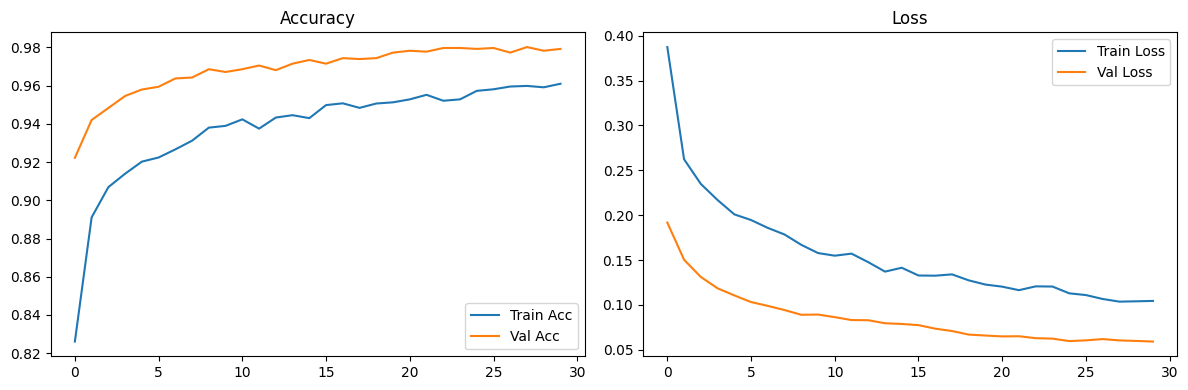

1/1 [==============================] - 0s 70ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       542
       COVID       0.98      0.99      0.99      1528

    accuracy                           0.98      2070
   macro avg       0.97      0.97      0.97      2070
weighted avg       0.98      0.98      0.98      2070



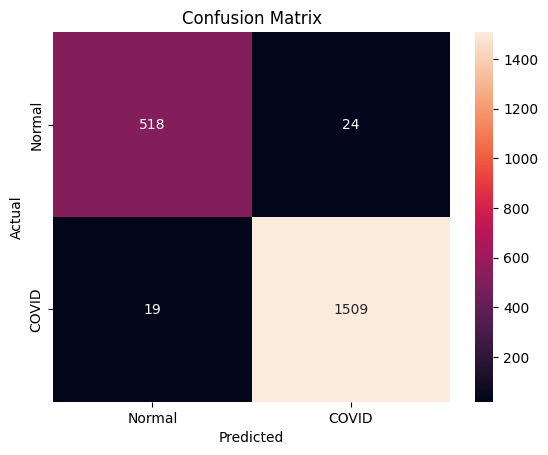


===== Training EfficientNetB0 =====
Found 9665 files belonging to 2 classes.
Found 2070 files belonging to 2 classes.
Epoch 1/30
1209/1209 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8066
[Epoch 1 Resource Check]
  RAM Used: 10.33 GB (65.8%)
  GPU Used: 52 MB (peak: 128 MB)
1209/1209 [==============================] - 177s 135ms/step - loss: 0.4304 - accuracy: 0.8066 - val_loss: 0.1634 - val_accuracy: 0.9391 - lr: 1.0000e-04
Epoch 2/30
1209/1209 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8899
[Epoch 2 Resource Check]
  RAM Used: 10.30 GB (65.6%)
  GPU Used: 52 MB (peak: 128 MB)
1209/1209 [==============================] - 162s 134ms/step - loss: 0.2737 - accuracy: 0.8899 - val_loss: 0.1343 - val_accuracy: 0.9507 - lr: 1.0000e-04
Epoch 3/30
1209/1209 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9025
[Epoch 3 Resource Check]
  RAM Used: 10.50 GB (66.9%)
  GPU Used: 52 MB (peak: 128 MB)
1209/1209 [=======

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [1]:
# Transfer Learning for COVID/Normal Classification with Memory Monitoring (RTX 3060 + 16GB RAM Optimized)

import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam

# Configure GPU for RTX 3060 (6GB)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
            )
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("GPU configured with mixed precision (5GB limit)")
    except RuntimeError as e:
        print(f"GPU error: {e}")
else:
    print("No GPU found.")

# Paths
DATA_DIR = r"E:\\covid_xray_classification\\data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

# Resource monitor callback
class ResourceMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\n[Epoch {epoch+1} Resource Check]")
        ram = psutil.virtual_memory()
        print(f"  RAM Used: {(ram.total - ram.available) / (1024**3):.2f} GB ({ram.percent}%)")
        try:
            mem = tf.config.experimental.get_memory_info('GPU:0')
            print(f"  GPU Used: {mem['current'] / 1024**2:.0f} MB (peak: {mem['peak'] / 1024**2:.0f} MB)")
        except:
            print("  GPU memory info not available")
        gc.collect()

# Build model
def build_model(base_model_fn, preprocess_func):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dataset creator
def get_dataset(directory, preprocess_func, batch_size=BATCH_SIZE):
    ds = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=True
    )
    ds = ds.map(lambda x, y: (preprocess_func(tf.cast(x, tf.float32)), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

# Training and evaluation pipeline
def train_model(model_name, base_fn, preprocess_fn):
    print(f"\n===== Training {model_name} =====")
    model = build_model(base_fn, preprocess_fn)

    train_ds = get_dataset(os.path.join(DATA_DIR, 'train'), preprocess_fn)
    val_ds = get_dataset(os.path.join(DATA_DIR, 'val'), preprocess_fn)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        ResourceMonitor()
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=callbacks
    )

    model.save(os.path.join(DATA_DIR, f"{model_name.lower()}_model.h5"))
    print(f"Saved model: {model_name.lower()}_model.h5")
    return model, val_ds, history

# Evaluation
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for X, y in dataset:
        pred = model.predict(X)
        y_true.extend(y.numpy().astype(int))
        y_pred.extend((pred > 0.5).astype(int).flatten())

    print(classification_report(y_true, y_pred, target_names=['Normal', 'COVID']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'COVID'], yticklabels=['Normal', 'COVID'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot training
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":
    for name, fn, preproc in [
        ("DenseNet121", DenseNet121, preprocess_densenet),
        ("EfficientNetB0", EfficientNetB0, preprocess_efficientnet)
    ]:
        model, val_ds, history = train_model(name, fn, preproc)
        plot_training(history)
        evaluate_model(model, val_ds)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
GPU configured with mixed precision (5GB limit)

🚀 Starting EfficientNetB0 training...

===== Training EfficientNetB0 =====
Found 9665 files belonging to 2 classes.
Found 2070 files belonging to 2 classes.
Epoch 1/30
1209/1209 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8060
[Epoch 1 Resource Check]
  RAM Used: 13.58 GB (86.5%)
  GPU Used: 18 MB (peak: 87 MB)
1209/1209 [==============================] - 187s 142ms/step - loss: 0.4316 - accuracy: 0.8060 - val_loss: 0.1676 - val_accuracy: 0.9372 - lr: 1.0000e-04
Epoch 2/30
1209/1209 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.8857
[Epoch 2 Resource Check]
  RAM Used: 13.50 GB (86.0%)
  GPU Used: 18 MB (peak: 87 MB)
1209/1209 [=========

INFO:tensorflow:Assets written to: E:\\covid_xray_classification\\data\efficientnetb0_model\assets


INFO:tensorflow:Assets written to: E:\\covid_xray_classification\\data\efficientnetb0_model\assets


✗ Failed to save SavedModel: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

📊 Generating plots...


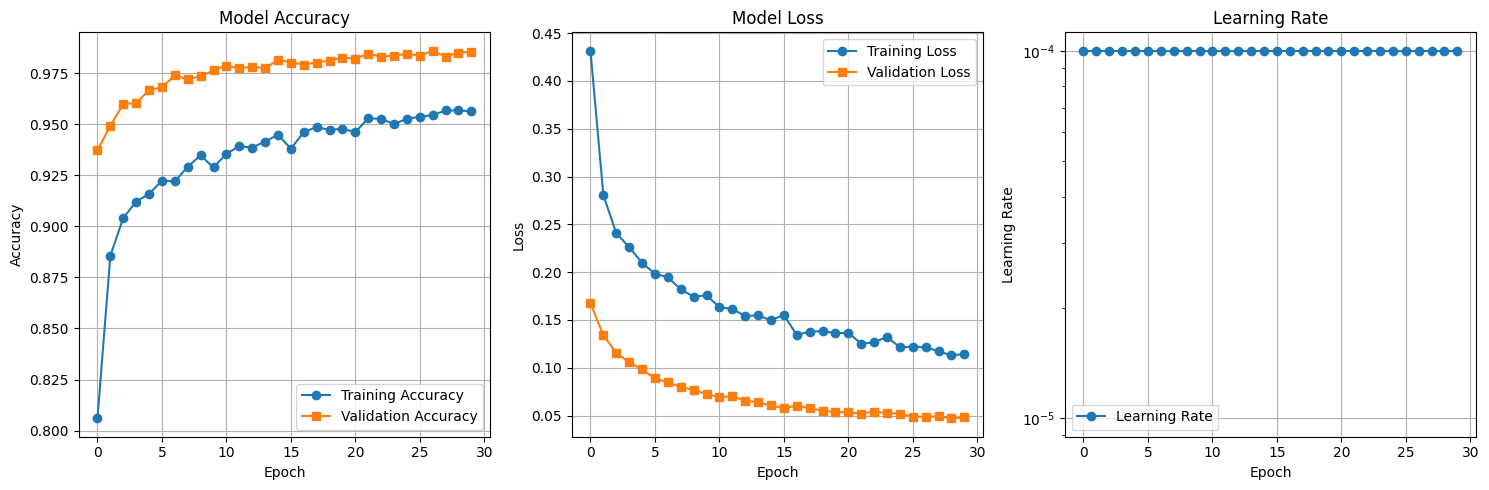


📈 Evaluating model...

===== Model Evaluation =====
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97       542
       COVID       0.99      0.99      0.99      1528

    accuracy                           0.99      2070
   macro avg       0.98      0.98      0.98      2070
weighted avg       0.99      0.99      0.99      2070


Detailed Metrics:
Accuracy: 0.9855 (98.55%)
Precision: 0.9876
Recall (Sensitivity): 0.9928
Specificity: 0.9649
F1-Score: 0.9902
Total samples: 2070
COVID cases: [1528]
Normal cases: [542]


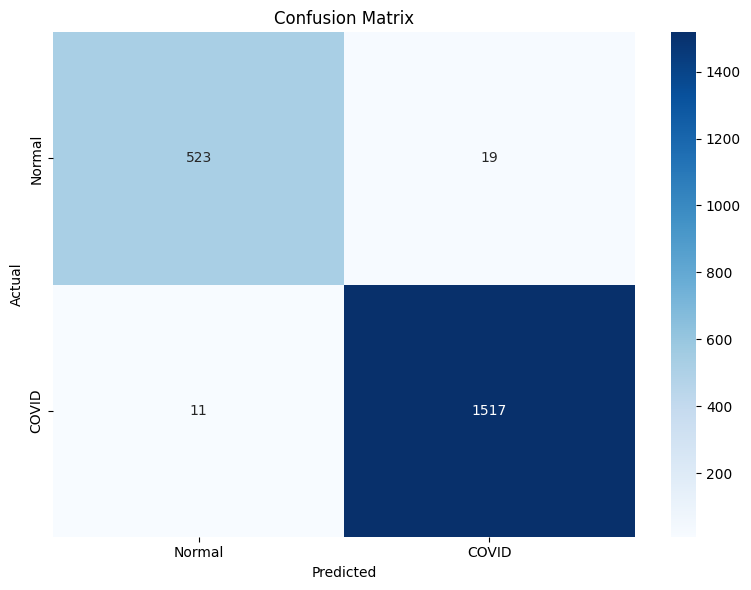


✅ EfficientNetB0 training and evaluation completed successfully!

🎉 All processing completed!


In [1]:
# Transfer Learning for COVID/Normal Classification - Fixed Version

import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam

# Configure GPU for RTX 3060 (6GB)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
            )
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("GPU configured with mixed precision (5GB limit)")
    except RuntimeError as e:
        print(f"GPU error: {e}")
else:
    print("No GPU found.")

# Paths
DATA_DIR = r"E:\\covid_xray_classification\\data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

# Resource monitor callback
class ResourceMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\n[Epoch {epoch+1} Resource Check]")
        ram = psutil.virtual_memory()
        print(f"  RAM Used: {(ram.total - ram.available) / (1024**3):.2f} GB ({ram.percent}%)")
        try:
            mem = tf.config.experimental.get_memory_info('GPU:0')
            print(f"  GPU Used: {mem['current'] / 1024**2:.0f} MB (peak: {mem['peak'] / 1024**2:.0f} MB)")
        except:
            print("  GPU memory info not available")
        gc.collect()

# Build model
def build_model(base_model_fn, preprocess_func):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dataset creator
def get_dataset(directory, preprocess_func, batch_size=BATCH_SIZE):
    ds = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=True
    )
    ds = ds.map(lambda x, y: (preprocess_func(tf.cast(x, tf.float32)), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

# Training and evaluation pipeline with robust saving
def train_model(model_name, base_fn, preprocess_fn):
    print(f"\n===== Training {model_name} =====")
    model = build_model(base_fn, preprocess_fn)

    train_ds = get_dataset(os.path.join(DATA_DIR, 'train'), preprocess_fn)
    val_ds = get_dataset(os.path.join(DATA_DIR, 'val'), preprocess_fn)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        ResourceMonitor()
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,  # Changed back to 30 from 3
        callbacks=callbacks
    )

    # Enhanced saving with multiple fallbacks
    model_path = os.path.join(DATA_DIR, f"{model_name.lower()}_model")
    
    # Try multiple saving methods
    save_success = False
    
    # Method 1: Try saving weights only (most reliable)
    try:
        weights_path = model_path + "_weights.h5"
        model.save_weights(weights_path)
        print(f"✓ Saved model weights: {weights_path}")
        save_success = True
    except Exception as e:
        print(f"✗ Failed to save weights: {e}")
    
    # Method 2: Try H5 format
    try:
        h5_path = model_path + ".h5"
        model.save(h5_path, save_format='h5')
        print(f"✓ Saved model (H5): {h5_path}")
        save_success = True
    except Exception as e:
        print(f"✗ Failed to save H5: {e}")
    
    # Method 3: Try SavedModel format (original attempt)
    try:
        model.save(model_path, save_format='tf')
        print(f"✓ Saved model (SavedModel): {model_path}")
        save_success = True
    except Exception as e:
        print(f"✗ Failed to save SavedModel: {e}")
    
    # Method 4: Save architecture and weights separately
    if not save_success:
        try:
            # Save architecture
            arch_path = model_path + "_architecture.json"
            with open(arch_path, 'w') as f:
                f.write(model.to_json())
            
            # Save weights
            weights_path = model_path + "_weights_backup.h5"
            model.save_weights(weights_path)
            
            print(f"✓ Saved architecture: {arch_path}")
            print(f"✓ Saved weights backup: {weights_path}")
            save_success = True
        except Exception as e:
            print(f"✗ Failed to save architecture/weights: {e}")
    
    if not save_success:
        print("⚠️  Warning: Could not save model, but training completed successfully!")
        print("   You can still use the model for evaluation in this session.")
    
    return model, val_ds, history

# Enhanced evaluation with more metrics
def evaluate_model(model, dataset):
    print("\n===== Model Evaluation =====")
    y_true, y_pred_proba, y_pred = [], [], []
    
    for X, y in dataset:
        pred = model.predict(X, verbose=0)
        y_true.extend(y.numpy().astype(int))
        y_pred_proba.extend(pred.flatten())
        y_pred.extend((pred > 0.5).astype(int).flatten())

    # Classification report
    print(classification_report(y_true, y_pred, target_names=['Normal', 'COVID']))
    
    # Additional metrics
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Total samples: {len(y_true)}")
    print(f"COVID cases: {sum(y_true)}")
    print(f"Normal cases: {len(y_true) - sum(y_true)}")
    
    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'COVID'], 
                yticklabels=['Normal', 'COVID'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Enhanced plotting
def plot_training(history):
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Learning rate plot (if available)
    if 'lr' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate', marker='o')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
    else:
        # Show final metrics instead
        plt.subplot(1, 3, 3)
        final_metrics = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']
        final_values = [
            history.history['accuracy'][-1],
            history.history['val_accuracy'][-1],
            history.history['loss'][-1],
            history.history['val_loss'][-1]
        ]
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']
        plt.barh(final_metrics, final_values, color=colors)
        plt.title('Final Metrics')
        plt.xlabel('Value')
        for i, v in enumerate(final_values):
            plt.text(v + 0.01, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

# Main execution with error handling
if __name__ == "__main__":
    for name, fn, preproc in [
        ("EfficientNetB0", EfficientNetB0, preprocess_efficientnet)
    ]:
        try:
            print(f"\n🚀 Starting {name} training...")
            model, val_ds, history = train_model(name, fn, preproc)
            
            print(f"\n📊 Generating plots...")
            plot_training(history)
            
            print(f"\n📈 Evaluating model...")
            evaluate_model(model, val_ds)
            
            print(f"\n✅ {name} training and evaluation completed successfully!")
            
        except Exception as e:
            print(f"\n❌ Error during {name} processing: {e}")
            import traceback
            traceback.print_exc()
            
            # Try to continue with evaluation if model exists
            if 'model' in locals() and 'val_ds' in locals():
                print("\n🔄 Attempting evaluation with existing model...")
                try:
                    evaluate_model(model, val_ds)
                except Exception as eval_error:
                    print(f"Evaluation also failed: {eval_error}")
    
    print("\n🎉 All processing completed!")

In [2]:
def plot_training(history):
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Learning rate plot (if available)
    if 'lr' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
    else:
        # Show final metrics instead
        plt.subplot(1, 3, 3)
        final_metrics = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']
        final_values = [
            history.history['accuracy'][-1],
            history.history['val_accuracy'][-1],
            history.history['loss'][-1],
            history.history['val_loss'][-1]
        ]
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']
        plt.barh(final_metrics, final_values, color=colors)
        plt.title('Final Metrics')
        plt.xlabel('Value')
        for i, v in enumerate(final_values):
            plt.text(v + 0.01, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

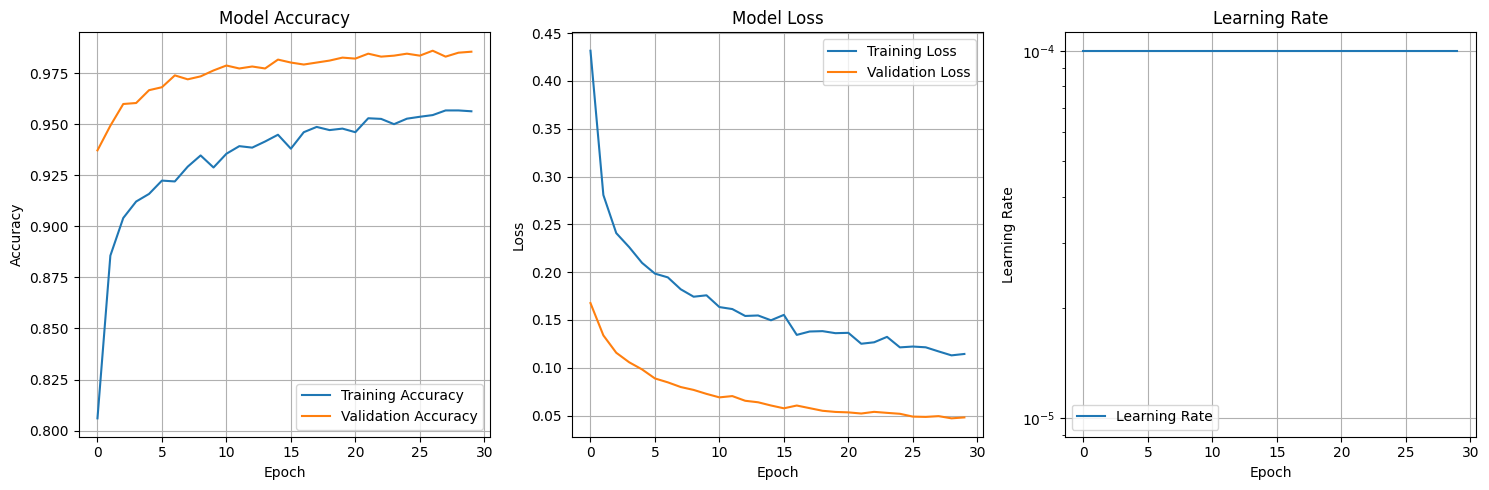

In [3]:
plot_training(history)